### Unzipping the files

In [1]:
!unzip "/content/drive/My Drive/Participants_Data_cvdc2020.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Participants_Data_cvdc2020/Train/83126.jpg  
  inflating: Participants_Data_cvdc2020/Train/68839.jpg  
  inflating: Participants_Data_cvdc2020/Train/77919.jpg  
  inflating: Participants_Data_cvdc2020/Train/75868.jpg  
  inflating: Participants_Data_cvdc2020/Train/64965.jpg  
  inflating: Participants_Data_cvdc2020/Train/81057.jpg  
  inflating: Participants_Data_cvdc2020/Train/83640.jpg  
  inflating: Participants_Data_cvdc2020/Train/57377.jpg  
  inflating: Participants_Data_cvdc2020/Train/57363.jpg  
  inflating: Participants_Data_cvdc2020/Train/83654.jpg  
  inflating: Participants_Data_cvdc2020/Train/81043.jpg  
  inflating: Participants_Data_cvdc2020/Train/81725.jpg  
  inflating: Participants_Data_cvdc2020/Train/83132.jpg  
  inflating: Participants_Data_cvdc2020/Train/72685.jpg  
  inflating: Participants_Data_cvdc2020/Train/62496.jpg  
  inflating: Participants_Data_cvdc2020/Train/63788.jpg  
  inflating: Particip

In [2]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


--2020-09-21 09:48:27--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-09-21 09:48:28 (43.5 MB/s) - ‘helper.py’ saved [2813/2813]



### Importation-1



In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
import helper

In [4]:
pip install torchdata

### Dataset

In [5]:
df=pd.read_csv("/content/Participants_Data_cvdc2020/Train.csv")

In [6]:
df.head()

,file_id,species,file_name
0,55502,Abies concolor,55502.jpg
1,55510,Abies concolor,55510.jpg
2,55515,Abies concolor,55515.jpg
3,55516,Abies concolor,55516.jpg
4,55517,Abies concolor,55517.jpg


In [7]:
df["species"].value_counts()

Maclura pomifera            157
Ulmus rubra                 111
Prunus virginiana           106
Acer rubrum                 104
Broussonettia papyrifera    103
                           ... 
Styrax obassia               28
Quercus rubra                25
Toona sinensis               22
Quercus falcata              21
Magnolia soulangiana         20
Name: species, Length: 185, dtype: int64

### LabelEncoding Target

In [9]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
df["value"]=lb.fit_transform(df.species)

In [10]:
df.head()

,file_id,species,file_name,value
0,55502,Abies concolor,55502.jpg,0
1,55510,Abies concolor,55510.jpg,0
2,55515,Abies concolor,55515.jpg,0
3,55516,Abies concolor,55516.jpg,0
4,55517,Abies concolor,55517.jpg,0


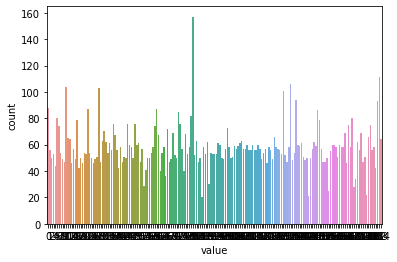

In [14]:
sns.countplot(x="value",data=df)

### Train-Val split

In [15]:
from sklearn.model_selection import train_test_split
train,val=train_test_split(df,test_size=0.33,stratify=df.value)

In [16]:
len(train), len(val)

(7238, 3565)

In [17]:
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

### Dataset--> Dataframe--> Dictionary of Image and Target value

In [18]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 2])
        image = io.imread(img_name)
        label = self.dataframe.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'target': label}

        

        return sample

### Sample Image without Transformations

4 (600, 800, 3) 13


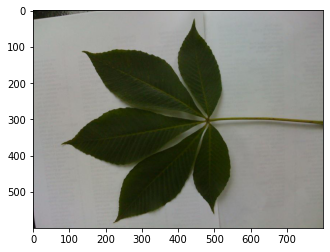

In [34]:
face_dataset = FaceLandmarksDataset(csv_file='/content/train.csv',
                                    root_dir='/content/Participants_Data_cvdc2020/Train')
sample = face_dataset[700]
print(4, sample['image'].shape, sample['target'])
plt.imshow(sample["image"])

### "TRANSFORMATIONS" done on Images

In [31]:
transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(300),
    transforms.CenterCrop(224), # because this method is used for PIL Image dtype
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
     # because inpus dtype is PIL Image
])

### Sample Image with Transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 torch.Size([3, 224, 224]) 13


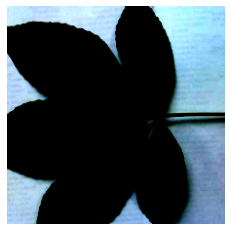

In [33]:
transformed_dataset = FaceLandmarksDataset(csv_file='/content/train.csv',
                                    root_dir='/content/Participants_Data_cvdc2020/Train',transform=transformation)
sample=transformed_dataset[700]
print(4, sample['image'].shape, sample['target'])
helper.imshow(sample["image"], normalize=False)

### Creating DataLoader

In [35]:
image_datasets = {x:FaceLandmarksDataset(csv_file="/content/"+x+".csv",
                                    root_dir='/content/Participants_Data_cvdc2020/Train',transform=transformation)
                  for x in ['train', 'val']}

In [36]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

In [37]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

### Sample Image from DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
tensor(16)


tensor([130,  13, 130, 103,  16,  93, 161, 116])

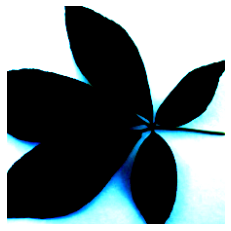

In [53]:
images, labels =((next(iter(dataloaders["train"])).values()))
helper.imshow(images[4], normalize=False)
print(images[4].shape)
print(labels[4])
(labels)

### Importations-2

In [54]:
import time
import os
import copy
import torch
from torchvision import datasets, transforms,models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import helper
import pandas as pd
import time
import os

### Selecting Device

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
print(device)

cuda


### MODEL

In [57]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 185)

model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### Training Loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch["image"]
                labels = batch["target"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 3.6356 Acc: 0.2393
val Loss: 1.8698 Acc: 0.5209

Epoch 1/9
----------
train Loss: 1.7605 Acc: 0.5794
val Loss: 1.0653 Acc: 0.6999

Epoch 2/9
----------
train Loss: 1.0975 Acc: 0.7383
val Loss: 0.7949 Acc: 0.7762

Epoch 3/9
----------
train Loss: 0.7233 Acc: 0.8382
val Loss: 0.6143 Acc: 0.8202

Epoch 4/9
----------
train Loss: 0.5021 Acc: 0.8922
val Loss: 0.5395 Acc: 0.8435

Epoch 5/9
----------
train Loss: 0.3469 Acc: 0.9304
val Loss: 0.4655 Acc: 0.8583

Epoch 6/9
----------
train Loss: 0.2329 Acc: 0.9620
val Loss: 0.4192 Acc: 0.8752

Epoch 7/9
----------
train Loss: 0.1349 Acc: 0.9849
val Loss: 0.3710 Acc: 0.8934

Epoch 8/9
----------
train Loss: 0.1188 Acc: 0.9892
val Loss: 0.3609 Acc: 0.8959

Epoch 9/9
----------
train Loss: 0.1113 Acc: 0.9894
val Loss: 0.3570 Acc: 0.8973

Training complete in 30m 48s
Best val Acc: 0.897335
